In [1]:
%env MUJOCO_GL=egl
%matplotlib widget

env: MUJOCO_GL=egl


In [2]:
import uitb
from uitb import test as uitb_test
import os

import numpy as np
import pandas as pd
# import mujoco
# import matplotlib.pyplot as plt

In [3]:
REMOTE_DISPLAY = True
###TODO: test with other OS than Ubuntu

if REMOTE_DISPLAY:
    process = os.popen("hostname --ip-address")
    _myipaddress = process.read().split()[0]
    process.close()

    # os.environ["DISPLAY"] = f"{_myipaddress}:1"  #run remotely (X server needs to be configured to accept remote connections, see https://askubuntu.com/a/34663)
    os.environ["DISPLAY"] = f":1"  #run remotely (X server needs to be configured to accept remote connections, see https://askubuntu.com/a/34663)

    process = os.popen("echo /run/user/$(id -u)")
    _pam = process.read().split("\n")[0]
    process.close()

    os.environ["XDG_RUNTIME_DIR"] = _pam
else:
    # use X11 forwarding (e.g., using MobaXterm)
    os.environ["DISPLAY"] = "localhost:10.0"  #forward to localhost:10.0

## Reach Envelope
[adapted from reacher_sg's reacherutils.py and ReacherSG_trajectory-analysis.ipynb, and then from uitb-vr_testing.ipynb]

### Set simulation parameters

In [4]:
SIMULATOR_NAME = "unity_random_3ccr_1e1_v115"
USE_CLONED = False

RUN_PARAMETERS = {"action_sample_freq": 20,"evaluate": True}
USE_VR_CONTROLLER = True  #whether to use VR controller position or that of the welded body ##(the latter does not require calling mj_step, and thus results in the hypothetical reach envelope of the hand, ignoring the offset to the VR controller)

### Observe reach envelope

In [5]:
if "test_env" in locals():
    del test_env

simulator_path = os.path.join(os.path.dirname(uitb.__path__[0]), "simulators", SIMULATOR_NAME)
test_env = uitb.Simulator.get(simulator_path, run_parameters=RUN_PARAMETERS, render_mode="rgb_array", use_cloned=USE_CLONED)

welded_body = test_env.config["simulation"]["task"]["kwargs"]["right_controller_body"]
relpose = test_env.config["simulation"]["task"]["kwargs"]["right_controller_relpose"]
endeffector_name = "controller-right" if USE_VR_CONTROLLER else welded_body

video_output = True
num_episodes = 1
video_filename = f'/home/florian/uitb-sim2vr/user-in-the-box-private/uitb_distance_{endeffector_name}_test.mp4'
figure_filename = f'/home/florian/uitb-sim2vr/user-in-the-box-private/uitb_distance_{endeffector_name}_test.png'
table_filename = f'/home/florian/uitb-sim2vr/user-in-the-box-private/uitb_distance_{endeffector_name}_test.csv'
trajectories_table_columns = ['elv_angle_pos', 'shoulder_elv_pos'] + ['end-effector_xpos' + suffix for
                                                                        suffix in ('_x', '_y', '_z')]

uitb_test.ReachEnvelopeCheck(test_env,
                       USE_VR_CONTROLLER,
                       welded_body,
                       relpose,
                       endeffector_name,
                       trajectories_table_columns,
                       num_episodes,
                       video_output,
                       figure_filename,
                       table_filename,
                       video_filename
                       )

Attempting to connect to Unity app on port 42159
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-

### Define target positions

In [7]:
# read Unity target coordinates from event files
task_condition_list = ["13-01-15-low-medium", "13-01-55-mid-medium", "13-02-34-high-medium"]
_target_info = pd.DataFrame()
for _task_condition in task_condition_list:
    _filename = os.path.join(os.path.dirname(uitb.__path__[0]), "datasets", f"vr-uitb-experiment/85/{_task_condition}/events.csv")
    with open(_filename, "r") as f:
        _lines = f.read().split("\n")
    _firstrowindex = np.where(["grid mapping" in _l for _l in _lines])[0][-1] + 1
    _target_info_new = pd.DataFrame(np.vstack([np.fromstring(_i.replace("[", "").strip(), dtype=float, sep=" ") for _i in _lines[_firstrowindex-1].split("grid mapping")[-1].split("]")[:-1]]), columns=["id", "j", "i", "local_x", "local_y", "global_x", "global_y", "global_z"]).astype(dict(zip(["id", "j", "i", "local_x", "local_y", "global_x", "global_y", "global_z"], [int, int, int, float, float, float, float, float])))
    _target_info_new["task_condition"] = _task_condition
    _target_info = pd.concat((_target_info, _target_info_new))
_target_info

,id,j,i,local_x,local_y,global_x,global_y,global_z,task_condition
0,0,0,0,-0.125,0.125,0.026594,0.940631,0.594708,13-01-15-low-medium
1,3,1,0,-0.125,0.000,0.026594,0.852242,0.506320,13-01-15-low-medium
2,6,2,0,-0.125,-0.125,0.026594,0.763854,0.417931,13-01-15-low-medium
3,1,0,1,0.000,0.125,0.151594,0.940631,0.594708,13-01-15-low-medium
4,4,1,1,0.000,0.000,0.151594,0.852242,0.506320,13-01-15-low-medium
5,7,2,1,0.000,-0.125,0.151594,0.763854,0.417931,13-01-15-low-medium
6,2,0,2,0.125,0.125,0.276594,0.940631,0.594708,13-01-15-low-medium
7,5,1,2,0.125,0.000,0.276594,0.852242,0.506320,13-01-15-low-medium
8,8,2,2,0.125,-0.125,0.276594,0.763854,0.417931,13-01-15-low-medium
0,0,0,0,-0.125,0.125,0.026594,1.194920,0.563642,13-01-55-mid-medium


### Check reachability

Create figure

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

sns.set_theme(style="white")  #, palette=None)
sns.reset_orig()

In [34]:
%matplotlib inline
plt.close("all")

/tmp/ipykernel_2217850/3237228978.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig_distance.tight_layout()


ReachEnvelope figure stored at '/home/florian/uitb-sim2vr/user-in-the-box-private/uitb_distance_controller-right_test.png'.


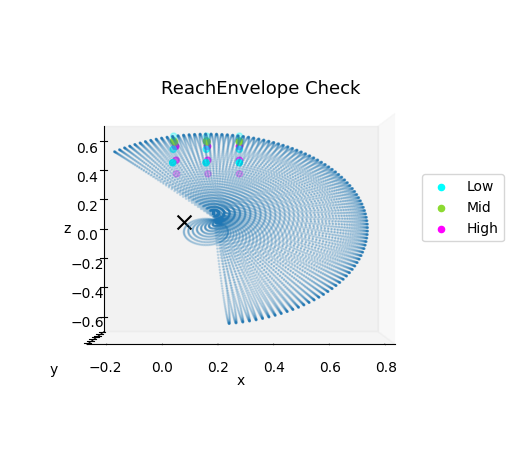

In [69]:
##TODO: disentangle code for regular figure plot and animation below; clean code

fig_distance = plt.figure() #figsize=(15, 9)) #dpi=300)
ax_distance = fig_distance.add_subplot(projection='3d')

############################

_gradual = False   #whether to gradually draw reach envelope lines  #TODO: move to animation below

############################

ax_distance.clear()

ax_distance.view_init(elev=0, azim=-90)
# ax_distance.view_init(elev=-180, azim=-135)
ax_distance.set_xlabel('x')
ax_distance.set_ylabel('y')
ax_distance.set_zlabel('z')

distance_test = pd.read_csv(table_filename, index_col=0)

#transfer reach envelope from MuJoCo to global Unity coordinates
distance_test_unity = distance_test.copy()
distance_test_unity.loc[:, "end-effector_xpos_x":"end-effector_xpos_z"] = np.array(distance_test_unity.apply(lambda x: np.array(list(test_env.task._transform_to_unity(x.loc["end-effector_xpos_x":"end-effector_xpos_z"].values, test_env._data.body("controller-right").xquat, apply_offset=True)[0].values())), axis=1).tolist())
# ax_distance.invert_yaxis()

# ax_distance.scatter(distance_test_unity["end-effector_xpos_x"], distance_test_unity["end-effector_xpos_z"], distance_test_unity["end-effector_xpos_y"], c="#eda840", s=0.8, alpha=0.2)
if _gradual:
    distance_lines, = ax_distance.plot(distance_test_unity["end-effector_xpos_x"], distance_test_unity["end-effector_xpos_y"], distance_test_unity["end-effector_xpos_z"], c="#eda840", alpha=0.2)
else:
    ax_distance.scatter(distance_test_unity["end-effector_xpos_x"], distance_test_unity["end-effector_xpos_y"], distance_test_unity["end-effector_xpos_z"], s=0.8, alpha=0.2)

#plot shoulder
_shoulder_unity = np.array(list(test_env.task._transform_to_unity(test_env._data.body("clavicle").xpos, test_env._data.body("clavicle").xquat, apply_offset=True)[0].values()))
# ax_distance.scatter(*_shoulder_unity, marker="x", c="black", s=100)
ax_distance.scatter(_shoulder_unity[0], _shoulder_unity[1], _shoulder_unity[2], marker="x", c="black", s=100)

# ax_distance.set_title("BioCheck: Reach Envelope\n(MoblArmsWrist, Whac-a-mole)")
ax_distance.text(0, 0, 0.8, "ReachEnvelope Check", size=13)
# ax_distance.title.set_position((0.5, -1))
ax_distance.set_yticklabels([])
ax_distance.grid(False)

## plot targets from VR Application in global Unity coordinates
# _color_list = ["#119bf4", "#8cda31", "#ff00ff"]
_color_list = ["#00ffff", "#8cda31", "#ff00ff"]
for _idx, _task_condition in enumerate(_target_info["task_condition"].unique()):
    _target_info_selected = _target_info[_target_info["task_condition"] == _task_condition]
    ax_distance.scatter(_target_info_selected["global_x"], _target_info_selected["global_y"], _target_info_selected["global_z"], label=_task_condition.lstrip('0123456789-').capitalize().split("-")[0], c=_color_list[_idx])
    # ax_distance.scatter(_target_info_selected["global_x"], _target_info_selected["global_z"], _target_info_selected["global_y"], label=_task_condition.lstrip('0123456789-').capitalize().split("-")[0], c=_color_list[_idx])

# ## target region (from SciRep RL paper)

# gphi = np.random.uniform(low=-1.57079633, high=0.698132, size=100000)
# #gphi = np.random.uniform(low=-1.57079633, high=-0.0872665, size=100000)
# gtheta = np.random.uniform(low=0, high=3.14159265, size=100000)
# gr = np.random.uniform(low=0.2, high=0.735, size=100000)  #high=0.735
# #ax_distance.scatter(gr*np.cos(gphi)*np.sin(gtheta), gr*np.sin(gphi)*np.sin(gtheta), gr*np.cos(gtheta), s=0.8)
# ax_distance.scatter(gr*np.cos(gphi)*np.sin(gtheta), gr*np.cos(gtheta), -gr*np.sin(gphi)*np.sin(gtheta), s=0.1, alpha=0.1)

# ## "random_v2":

# thorax_offset = np.array([0.02153019919, 0.00858509793, -0.20849523568])  #for unscaled model: np.array([0.017555, 0.007, -0.17])

# general_thorax_area = np.array([[-0.11157193, -0.32303762, -0.37799819], [0.12484449, 0.05684561, -0.03899228]])
# general_thorax_threshold = np.array([[-0.1, -2, -0.1], [0.1, 0.3, 0.1]])
# general_target_area = np.array([[0, -1, general_thorax_area[:, 2].mean()], [1, 1, 1]])

# nsamples_randomv2 = 10000
# new_target = np.zeros((nsamples_randomv2,3))
# for i in range(nsamples_randomv2):
#     draw_new_target = True
#     while draw_new_target:
#         new_target[i] = np.random.uniform(low=general_target_area[0], high=general_target_area[1], size=3)
#         if (np.linalg.norm(new_target[i]) <= 0.735 + 0.05) & ((new_target[i] < (general_thorax_area[0] + general_thorax_threshold[0])) |
#                 (new_target[i] > (general_thorax_area[1] + general_thorax_threshold[1]))).any():
#             draw_new_target = False

# ax_distance.scatter(new_target[:, 0], new_target[:, 1], new_target[:, 2], s=0.1, alpha=0.5)

ax_distance.legend(bbox_to_anchor=(0.9, 0.65)) #loc="right")  #loc=3)
# fig_distance.subplots_adjust(left=0.1, right=0.9, top=0.2, bottom=0.1)
fig_distance.tight_layout()
fig_distance.savefig(figure_filename)
print(f"ReachEnvelope figure stored at '{figure_filename}'.")

fig_distance.tight_layout()

Create animation

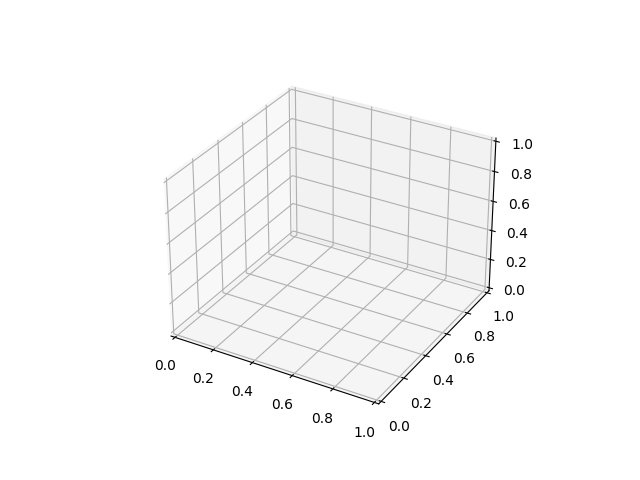

In [25]:
if "fig_anim_distance" in locals():
    plt.close("fig_anim_distance")

fig_anim_distance = plt.figure() #dpi=300)
ax_anim_distance = fig_anim_distance.add_subplot(111, projection='3d')

## 3D rotation animation
def init():
    ax_anim_distance.clear()
    ax_anim_distance.view_init(elev=10., azim=0)
    
    ax_anim_distance.set_xlabel('x')
    ax_anim_distance.set_ylabel('z')
    ax_anim_distance.set_zlabel('y')
    
    if _gradual:
        global distance_lines
        distance_lines, = ax_anim_distance.plot(distance_test_unity["end-effector_xpos_x"], distance_test_unity["end-effector_xpos_z"], distance_test_unity["end-effector_xpos_y"], c="#eda840", alpha=0.2)
    else:
        ax_anim_distance.scatter(distance_test_unity["end-effector_xpos_x"], distance_test_unity["end-effector_xpos_z"], distance_test_unity["end-effector_xpos_y"], c="#eda840", s=0.8, alpha=0.2)

    #plot shoulder
    _shoulder_unity = np.array(list(test_env.task._transform_to_unity(test_env._data.body("clavicle").xpos, test_env._data.body("clavicle").xquat, apply_offset=True)[0].values()))
    ax_anim_distance.scatter(_shoulder_unity[0], _shoulder_unity[2], _shoulder_unity[1], marker="x", c="black", s=100)

    for _idx, _task_condition in enumerate(_target_info["task_condition"].unique()):
        _target_info_selected = _target_info[_target_info["task_condition"] == _task_condition]
        ax_anim_distance.scatter(_target_info_selected["global_x"], _target_info_selected["global_z"], _target_info_selected["global_y"], label=_task_condition.lstrip('0123456789-').capitalize().split("-")[0], c=_color_list[_idx])
    ax_anim_distance.legend()

    return fig_anim_distance,

n_frames = 360
def animate(i):
    if _gradual:
        distance_lines.set_data(distance_test_unity["end-effector_xpos_x"][:int(distance_test_unity.shape[0]*i/n_frames)], distance_test_unity["end-effector_xpos_z"][:int(distance_test_unity.shape[0]*i/n_frames)],)
        distance_lines.set_3d_properties(distance_test_unity["end-effector_xpos_y"][:int(distance_test_unity.shape[0]*i/n_frames)])

    ax_anim_distance.view_init(elev=10., azim=i)
    return fig_anim_distance,


# Animate
anim = animation.FuncAnimation(fig_anim_distance, animate, init_func=init,
                               frames=n_frames, interval=20, blit=True)

In [ ]:
anim.save(f'uitb-vr_biocheck_animation{"_gradual" if _gradual else ""}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

: 